# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

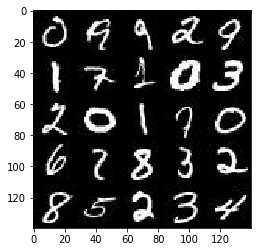

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

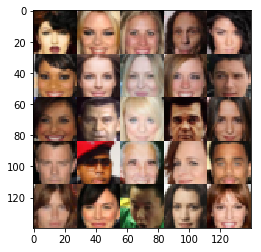

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #x1 = tf.nn.relu(x1)
        #print('discriminator x1:', x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        #x2 = tf.nn.relu(x2)
        #print('discriminator x2:', x2)
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        #x3 = tf.nn.relu(x3)
        #print('discriminator x3:', x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        #print('discriminator flat:', flat)
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train:
        reuse = False
    else:
        reuse = True

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1,(-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.nn.relu(x1)
        #print('generator x1:', x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        #x2 = tf.nn.relu(x2)
        #print('generator x2:', x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        #x3 = tf.nn.relu(x3)
        #print('generator x3:', x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print('generator logits:', logits)

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #ops_t = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    with tf.control_dependencies(ops):        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)  
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
  
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    sampless = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(sampless, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
from os.path import isdir
if not isdir('checkpoints'):
    !mkdir checkpoints

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    from time import time
    

    input_real, input_z, learnint_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
        
    #samples, losses = [], []
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            t0=time()
            for batch_images in get_batches(batch_size):
                # TODO: Train Model               
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...{}".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    #samples.append(samples)
            print('The residual time nearly to be:  {:.0f}  minutes.'.format((epoch_count-epoch_i-1)*(time()-t0)/60))
                    
                #saver.save(sess, './checkpoints/generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')
        
    #import pickle as pkl
    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    #return losses, samples  

    return 
        

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2...10 Discriminator Loss: 2.2004... Generator Loss: 0.4040
Epoch 1/2...20 Discriminator Loss: 1.6904... Generator Loss: 0.5977
Epoch 1/2...30 Discriminator Loss: 2.0229... Generator Loss: 0.6615
Epoch 1/2...40 Discriminator Loss: 1.4907... Generator Loss: 1.2730
Epoch 1/2...50 Discriminator Loss: 1.1860... Generator Loss: 2.2480
Epoch 1/2...60 Discriminator Loss: 0.6586... Generator Loss: 4.7769
Epoch 1/2...70 Discriminator Loss: 0.2491... Generator Loss: 5.2708
Epoch 1/2...80 Discriminator Loss: 0.1681... Generator Loss: 3.5763
Epoch 1/2...90 Discriminator Loss: 0.3942... Generator Loss: 2.6075
Epoch 1/2...100 Discriminator Loss: 0.2695... Generator Loss: 3.4157


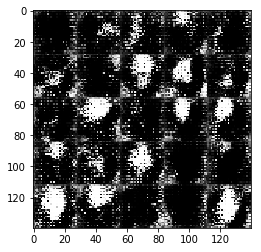

Epoch 1/2...110 Discriminator Loss: 0.2537... Generator Loss: 5.0689
Epoch 1/2...120 Discriminator Loss: 0.7794... Generator Loss: 5.3820
Epoch 1/2...130 Discriminator Loss: 1.0398... Generator Loss: 4.0285
Epoch 1/2...140 Discriminator Loss: 1.6129... Generator Loss: 4.1304
Epoch 1/2...150 Discriminator Loss: 8.7519... Generator Loss: 1.3587
Epoch 1/2...160 Discriminator Loss: 1.9339... Generator Loss: 3.0242
Epoch 1/2...170 Discriminator Loss: 2.1046... Generator Loss: 3.9150
Epoch 1/2...180 Discriminator Loss: 1.9915... Generator Loss: 1.9942
Epoch 1/2...190 Discriminator Loss: 8.7547... Generator Loss: 0.0519
Epoch 1/2...200 Discriminator Loss: 4.3693... Generator Loss: 5.4483


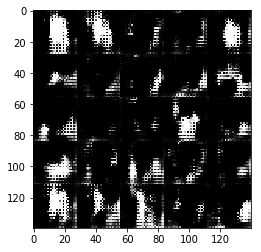

Epoch 1/2...210 Discriminator Loss: 3.1073... Generator Loss: 1.6716
Epoch 1/2...220 Discriminator Loss: 1.5238... Generator Loss: 2.8344
Epoch 1/2...230 Discriminator Loss: 1.2483... Generator Loss: 3.8816
Epoch 1/2...240 Discriminator Loss: 1.0874... Generator Loss: 2.3901
Epoch 1/2...250 Discriminator Loss: 0.3067... Generator Loss: 3.5329
Epoch 1/2...260 Discriminator Loss: 0.0328... Generator Loss: 4.6742
Epoch 1/2...270 Discriminator Loss: 0.0408... Generator Loss: 4.9374
Epoch 1/2...280 Discriminator Loss: 0.0774... Generator Loss: 4.8487
Epoch 1/2...290 Discriminator Loss: 0.1213... Generator Loss: 4.1551
Epoch 1/2...300 Discriminator Loss: 0.1603... Generator Loss: 3.7919


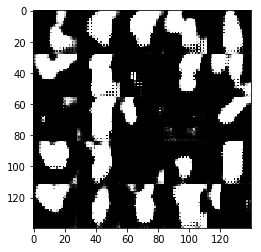

Epoch 1/2...310 Discriminator Loss: 0.1595... Generator Loss: 3.9330
Epoch 1/2...320 Discriminator Loss: 0.2225... Generator Loss: 2.8093
Epoch 1/2...330 Discriminator Loss: 0.5640... Generator Loss: 1.8835
Epoch 1/2...340 Discriminator Loss: 1.4742... Generator Loss: 1.2030
Epoch 1/2...350 Discriminator Loss: 0.8831... Generator Loss: 1.4547
Epoch 1/2...360 Discriminator Loss: 2.4489... Generator Loss: 0.7231
Epoch 1/2...370 Discriminator Loss: 0.6837... Generator Loss: 2.0526
Epoch 1/2...380 Discriminator Loss: 1.0029... Generator Loss: 2.5612
Epoch 1/2...390 Discriminator Loss: 1.6278... Generator Loss: 1.2402
Epoch 1/2...400 Discriminator Loss: 0.4680... Generator Loss: 3.3487


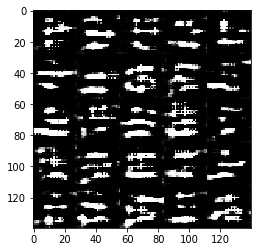

Epoch 1/2...410 Discriminator Loss: 0.4606... Generator Loss: 2.9991
Epoch 1/2...420 Discriminator Loss: 0.2107... Generator Loss: 3.1265
Epoch 1/2...430 Discriminator Loss: 0.0928... Generator Loss: 3.4864
Epoch 1/2...440 Discriminator Loss: 0.2252... Generator Loss: 3.3589
Epoch 1/2...450 Discriminator Loss: 0.1398... Generator Loss: 3.9003
Epoch 1/2...460 Discriminator Loss: 0.0461... Generator Loss: 4.6564
The residual time nearly to be:  6  minutes.
Epoch 2/2...470 Discriminator Loss: 0.1371... Generator Loss: 4.1983
Epoch 2/2...480 Discriminator Loss: 0.0777... Generator Loss: 4.2859
Epoch 2/2...490 Discriminator Loss: 0.0570... Generator Loss: 4.8606
Epoch 2/2...500 Discriminator Loss: 0.1259... Generator Loss: 4.0980


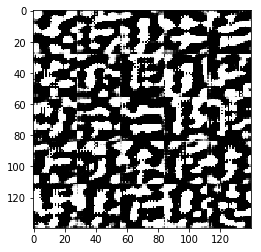

Epoch 2/2...510 Discriminator Loss: 0.1583... Generator Loss: 3.3743
Epoch 2/2...520 Discriminator Loss: 0.0414... Generator Loss: 4.3650
Epoch 2/2...530 Discriminator Loss: 0.0233... Generator Loss: 5.4656
Epoch 2/2...540 Discriminator Loss: 0.0361... Generator Loss: 4.7047
Epoch 2/2...550 Discriminator Loss: 0.0353... Generator Loss: 5.1313
Epoch 2/2...560 Discriminator Loss: 0.0346... Generator Loss: 4.9108
Epoch 2/2...570 Discriminator Loss: 0.0425... Generator Loss: 4.7658
Epoch 2/2...580 Discriminator Loss: 0.0776... Generator Loss: 4.5540
Epoch 2/2...590 Discriminator Loss: 0.0417... Generator Loss: 4.8892
Epoch 2/2...600 Discriminator Loss: 0.0568... Generator Loss: 5.0897


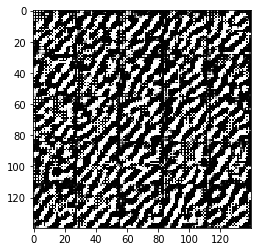

Epoch 2/2...610 Discriminator Loss: 0.0246... Generator Loss: 5.3019
Epoch 2/2...620 Discriminator Loss: 0.0385... Generator Loss: 4.4883
Epoch 2/2...630 Discriminator Loss: 0.1065... Generator Loss: 3.6132
Epoch 2/2...640 Discriminator Loss: 0.0549... Generator Loss: 5.2983
Epoch 2/2...650 Discriminator Loss: 0.0203... Generator Loss: 5.8438
Epoch 2/2...660 Discriminator Loss: 0.0143... Generator Loss: 5.9335
Epoch 2/2...670 Discriminator Loss: 0.0110... Generator Loss: 6.1141
Epoch 2/2...680 Discriminator Loss: 0.0117... Generator Loss: 5.9311
Epoch 2/2...690 Discriminator Loss: 0.0178... Generator Loss: 5.5576
Epoch 2/2...700 Discriminator Loss: 0.0147... Generator Loss: 5.4603


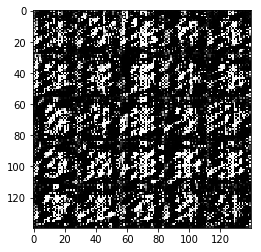

Epoch 2/2...710 Discriminator Loss: 0.0082... Generator Loss: 5.4112
Epoch 2/2...720 Discriminator Loss: 0.0091... Generator Loss: 5.8338
Epoch 2/2...730 Discriminator Loss: 0.0122... Generator Loss: 5.4173
Epoch 2/2...740 Discriminator Loss: 0.0143... Generator Loss: 5.8180
Epoch 2/2...750 Discriminator Loss: 0.0060... Generator Loss: 6.5759
Epoch 2/2...760 Discriminator Loss: 0.0049... Generator Loss: 6.6769
Epoch 2/2...770 Discriminator Loss: 0.0064... Generator Loss: 6.4744
Epoch 2/2...780 Discriminator Loss: 0.0085... Generator Loss: 6.1244
Epoch 2/2...790 Discriminator Loss: 0.0042... Generator Loss: 6.8698
Epoch 2/2...800 Discriminator Loss: 0.0047... Generator Loss: 7.1807


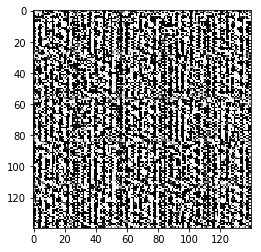

Epoch 2/2...810 Discriminator Loss: 0.0043... Generator Loss: 6.8181
Epoch 2/2...820 Discriminator Loss: 0.0062... Generator Loss: 6.4792
Epoch 2/2...830 Discriminator Loss: 0.0033... Generator Loss: 6.7534
Epoch 2/2...840 Discriminator Loss: 0.0021... Generator Loss: 7.3364
Epoch 2/2...850 Discriminator Loss: 0.0023... Generator Loss: 7.1058
Epoch 2/2...860 Discriminator Loss: 0.0046... Generator Loss: 6.6883
Epoch 2/2...870 Discriminator Loss: 0.0018... Generator Loss: 7.4412
Epoch 2/2...880 Discriminator Loss: 0.0011... Generator Loss: 7.4405
Epoch 2/2...890 Discriminator Loss: 0.0038... Generator Loss: 6.2200
Epoch 2/2...900 Discriminator Loss: 0.0032... Generator Loss: 6.3984


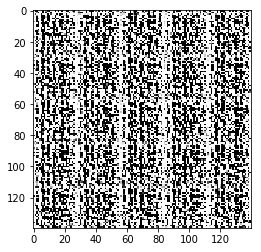

Epoch 2/2...910 Discriminator Loss: 0.0013... Generator Loss: 7.1992
Epoch 2/2...920 Discriminator Loss: 0.0014... Generator Loss: 7.1197
Epoch 2/2...930 Discriminator Loss: 0.0016... Generator Loss: 6.9920
The residual time nearly to be:  0  minutes.


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1...10 Discriminator Loss: 9.3703... Generator Loss: 0.8026
Epoch 1/1...20 Discriminator Loss: 2.2804... Generator Loss: 1.0260
Epoch 1/1...30 Discriminator Loss: 4.4341... Generator Loss: 0.5337
Epoch 1/1...40 Discriminator Loss: 0.4682... Generator Loss: 3.8094
Epoch 1/1...50 Discriminator Loss: 1.5065... Generator Loss: 2.9031
Epoch 1/1...60 Discriminator Loss: 0.7745... Generator Loss: 2.3885
Epoch 1/1...70 Discriminator Loss: 0.4307... Generator Loss: 2.9424
Epoch 1/1...80 Discriminator Loss: 0.6025... Generator Loss: 4.0796
Epoch 1/1...90 Discriminator Loss: 1.9399... Generator Loss: 2.3643
Epoch 1/1...100 Discriminator Loss: 1.3873... Generator Loss: 1.5656


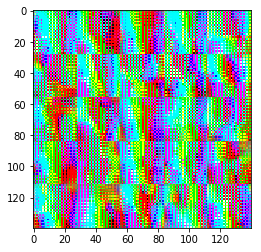

Epoch 1/1...110 Discriminator Loss: 1.1044... Generator Loss: 3.5716
Epoch 1/1...120 Discriminator Loss: 0.2196... Generator Loss: 6.9509
Epoch 1/1...130 Discriminator Loss: 0.6829... Generator Loss: 4.3929
Epoch 1/1...140 Discriminator Loss: 0.0437... Generator Loss: 7.1754
Epoch 1/1...150 Discriminator Loss: 0.2058... Generator Loss: 7.6271
Epoch 1/1...160 Discriminator Loss: 0.1523... Generator Loss: 6.6433
Epoch 1/1...170 Discriminator Loss: 0.0656... Generator Loss: 6.9320
Epoch 1/1...180 Discriminator Loss: 0.0652... Generator Loss: 6.5704
Epoch 1/1...190 Discriminator Loss: 0.0307... Generator Loss: 6.9935
Epoch 1/1...200 Discriminator Loss: 0.0480... Generator Loss: 6.6713


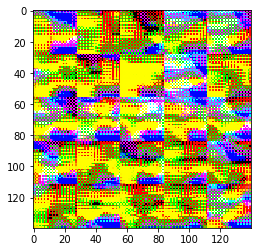

Epoch 1/1...210 Discriminator Loss: 0.0506... Generator Loss: 5.6635
Epoch 1/1...220 Discriminator Loss: 0.1966... Generator Loss: 4.7381
Epoch 1/1...230 Discriminator Loss: 0.1615... Generator Loss: 4.0068
Epoch 1/1...240 Discriminator Loss: 0.2528... Generator Loss: 4.2144
Epoch 1/1...250 Discriminator Loss: 0.3245... Generator Loss: 2.9393
Epoch 1/1...260 Discriminator Loss: 0.1553... Generator Loss: 4.8293
Epoch 1/1...270 Discriminator Loss: 0.2465... Generator Loss: 4.1045
Epoch 1/1...280 Discriminator Loss: 0.0606... Generator Loss: 6.2510
Epoch 1/1...290 Discriminator Loss: 0.0494... Generator Loss: 6.0384
Epoch 1/1...300 Discriminator Loss: 0.0525... Generator Loss: 5.4183


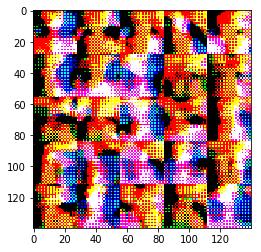

Epoch 1/1...310 Discriminator Loss: 0.2908... Generator Loss: 3.6785
Epoch 1/1...320 Discriminator Loss: 0.1654... Generator Loss: 4.1701
Epoch 1/1...330 Discriminator Loss: 0.1365... Generator Loss: 4.1939
Epoch 1/1...340 Discriminator Loss: 0.7100... Generator Loss: 2.8581
Epoch 1/1...350 Discriminator Loss: 0.2273... Generator Loss: 4.9220
Epoch 1/1...360 Discriminator Loss: 0.0334... Generator Loss: 6.5772
Epoch 1/1...370 Discriminator Loss: 0.0416... Generator Loss: 7.2427
Epoch 1/1...380 Discriminator Loss: 0.0406... Generator Loss: 8.1142
Epoch 1/1...390 Discriminator Loss: 0.0122... Generator Loss: 7.7598
Epoch 1/1...400 Discriminator Loss: 0.0235... Generator Loss: 5.9770


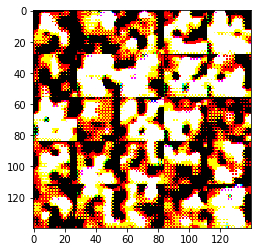

Epoch 1/1...410 Discriminator Loss: 0.0242... Generator Loss: 6.3913
Epoch 1/1...420 Discriminator Loss: 0.0086... Generator Loss: 8.0898
Epoch 1/1...430 Discriminator Loss: 0.0266... Generator Loss: 5.9091
Epoch 1/1...440 Discriminator Loss: 0.0118... Generator Loss: 6.5778
Epoch 1/1...450 Discriminator Loss: 0.0022... Generator Loss: 7.4743
Epoch 1/1...460 Discriminator Loss: 0.0029... Generator Loss: 6.7649
Epoch 1/1...470 Discriminator Loss: 0.0129... Generator Loss: 5.8436
Epoch 1/1...480 Discriminator Loss: 0.0143... Generator Loss: 5.6283
Epoch 1/1...490 Discriminator Loss: 0.0442... Generator Loss: 4.7596
Epoch 1/1...500 Discriminator Loss: 0.0188... Generator Loss: 5.3740


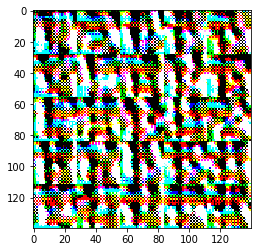

Epoch 1/1...510 Discriminator Loss: 0.0088... Generator Loss: 5.9689
Epoch 1/1...520 Discriminator Loss: 0.0087... Generator Loss: 6.3182
Epoch 1/1...530 Discriminator Loss: 0.0263... Generator Loss: 5.6951
Epoch 1/1...540 Discriminator Loss: 0.0126... Generator Loss: 5.7561
Epoch 1/1...550 Discriminator Loss: 0.0209... Generator Loss: 5.4162
Epoch 1/1...560 Discriminator Loss: 0.0113... Generator Loss: 5.7307
Epoch 1/1...570 Discriminator Loss: 0.0055... Generator Loss: 6.2782
Epoch 1/1...580 Discriminator Loss: 0.0041... Generator Loss: 6.4145
Epoch 1/1...590 Discriminator Loss: 0.0131... Generator Loss: 5.2429
Epoch 1/1...600 Discriminator Loss: 0.0058... Generator Loss: 6.1468


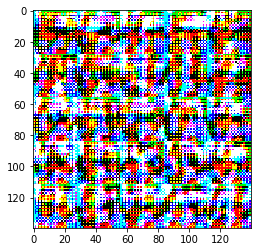

Epoch 1/1...610 Discriminator Loss: 0.0071... Generator Loss: 6.4898
Epoch 1/1...620 Discriminator Loss: 0.0033... Generator Loss: 6.4680
Epoch 1/1...630 Discriminator Loss: 0.0103... Generator Loss: 5.5168
Epoch 1/1...640 Discriminator Loss: 0.0059... Generator Loss: 6.0462
Epoch 1/1...650 Discriminator Loss: 0.0135... Generator Loss: 5.3631
Epoch 1/1...660 Discriminator Loss: 0.0091... Generator Loss: 5.7506
Epoch 1/1...670 Discriminator Loss: 0.0035... Generator Loss: 6.5735
Epoch 1/1...680 Discriminator Loss: 0.0032... Generator Loss: 6.8868
Epoch 1/1...690 Discriminator Loss: 0.0056... Generator Loss: 6.3471
Epoch 1/1...700 Discriminator Loss: 0.0013... Generator Loss: 7.8962


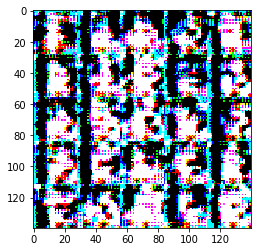

Epoch 1/1...710 Discriminator Loss: 0.0135... Generator Loss: 5.8547
Epoch 1/1...720 Discriminator Loss: 0.0021... Generator Loss: 7.5407
Epoch 1/1...730 Discriminator Loss: 0.0058... Generator Loss: 6.7512
Epoch 1/1...740 Discriminator Loss: 0.0034... Generator Loss: 6.8522
Epoch 1/1...750 Discriminator Loss: 0.0078... Generator Loss: 6.1149
Epoch 1/1...760 Discriminator Loss: 0.0026... Generator Loss: 7.0124
Epoch 1/1...770 Discriminator Loss: 0.0023... Generator Loss: 6.7777
Epoch 1/1...780 Discriminator Loss: 0.0042... Generator Loss: 6.6563
Epoch 1/1...790 Discriminator Loss: 0.0040... Generator Loss: 6.3682
Epoch 1/1...800 Discriminator Loss: 0.0017... Generator Loss: 7.3260


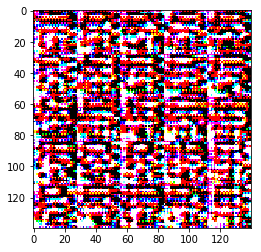

Epoch 1/1...810 Discriminator Loss: 0.0031... Generator Loss: 6.6136
Epoch 1/1...820 Discriminator Loss: 0.0023... Generator Loss: 6.9628
Epoch 1/1...830 Discriminator Loss: 0.0047... Generator Loss: 6.6627
Epoch 1/1...840 Discriminator Loss: 0.0060... Generator Loss: 5.8528
Epoch 1/1...850 Discriminator Loss: 0.0010... Generator Loss: 7.5390
Epoch 1/1...860 Discriminator Loss: 0.0005... Generator Loss: 8.1062
Epoch 1/1...870 Discriminator Loss: 0.0013... Generator Loss: 7.3523
Epoch 1/1...880 Discriminator Loss: 0.0013... Generator Loss: 7.4758
Epoch 1/1...890 Discriminator Loss: 0.0022... Generator Loss: 7.0211
Epoch 1/1...900 Discriminator Loss: 0.0041... Generator Loss: 6.4952


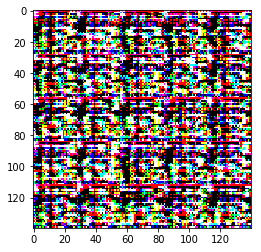

Epoch 1/1...910 Discriminator Loss: 0.0057... Generator Loss: 5.8542
Epoch 1/1...920 Discriminator Loss: 0.0021... Generator Loss: 6.8996
Epoch 1/1...930 Discriminator Loss: 0.0028... Generator Loss: 6.6484
Epoch 1/1...940 Discriminator Loss: 0.0028... Generator Loss: 6.5015
Epoch 1/1...950 Discriminator Loss: 0.0016... Generator Loss: 7.2737
Epoch 1/1...960 Discriminator Loss: 0.0014... Generator Loss: 7.3239
Epoch 1/1...970 Discriminator Loss: 0.0015... Generator Loss: 7.0472
Epoch 1/1...980 Discriminator Loss: 0.0017... Generator Loss: 7.5429
Epoch 1/1...990 Discriminator Loss: 0.0024... Generator Loss: 7.1624
Epoch 1/1...1000 Discriminator Loss: 0.0011... Generator Loss: 7.5093


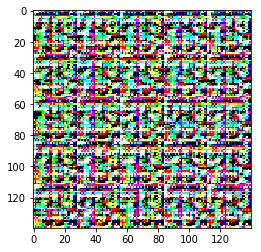

Epoch 1/1...1010 Discriminator Loss: 0.0008... Generator Loss: 7.7558
Epoch 1/1...1020 Discriminator Loss: 0.0020... Generator Loss: 7.7850
Epoch 1/1...1030 Discriminator Loss: 0.0005... Generator Loss: 8.2212
Epoch 1/1...1040 Discriminator Loss: 0.0018... Generator Loss: 7.9569
Epoch 1/1...1050 Discriminator Loss: 0.0008... Generator Loss: 8.3406
Epoch 1/1...1060 Discriminator Loss: 0.0001... Generator Loss: 9.9920
Epoch 1/1...1070 Discriminator Loss: 0.0003... Generator Loss: 8.9631
Epoch 1/1...1080 Discriminator Loss: 0.0012... Generator Loss: 7.4841
Epoch 1/1...1090 Discriminator Loss: 0.0005... Generator Loss: 8.3718
Epoch 1/1...1100 Discriminator Loss: 0.0005... Generator Loss: 8.3617


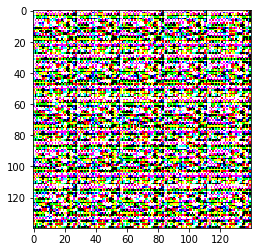

Epoch 1/1...1110 Discriminator Loss: 0.0008... Generator Loss: 7.9274
Epoch 1/1...1120 Discriminator Loss: 0.0014... Generator Loss: 7.1835
Epoch 1/1...1130 Discriminator Loss: 0.0007... Generator Loss: 7.8121
Epoch 1/1...1140 Discriminator Loss: 0.0003... Generator Loss: 8.5062
Epoch 1/1...1150 Discriminator Loss: 0.0003... Generator Loss: 8.4981
Epoch 1/1...1160 Discriminator Loss: 0.0006... Generator Loss: 7.8740
Epoch 1/1...1170 Discriminator Loss: 0.0002... Generator Loss: 9.5602
Epoch 1/1...1180 Discriminator Loss: 0.0001... Generator Loss: 9.3226
Epoch 1/1...1190 Discriminator Loss: 0.0002... Generator Loss: 9.8190
Epoch 1/1...1200 Discriminator Loss: 0.0001... Generator Loss: 9.2224


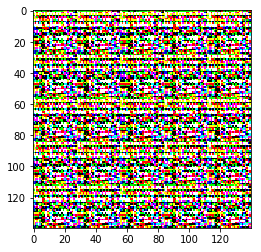

Epoch 1/1...1210 Discriminator Loss: 0.0001... Generator Loss: 9.4251
Epoch 1/1...1220 Discriminator Loss: 0.0001... Generator Loss: 9.5991
Epoch 1/1...1230 Discriminator Loss: 0.0001... Generator Loss: 9.7849
Epoch 1/1...1240 Discriminator Loss: 0.0002... Generator Loss: 9.3636
Epoch 1/1...1250 Discriminator Loss: 0.0002... Generator Loss: 10.2074
Epoch 1/1...1260 Discriminator Loss: 0.0001... Generator Loss: 9.8703
Epoch 1/1...1270 Discriminator Loss: 0.0000... Generator Loss: 10.2409
Epoch 1/1...1280 Discriminator Loss: 0.0001... Generator Loss: 10.7083
Epoch 1/1...1290 Discriminator Loss: 0.0000... Generator Loss: 10.6294
Epoch 1/1...1300 Discriminator Loss: 0.0000... Generator Loss: 10.5630


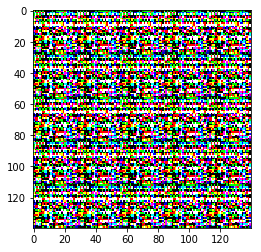

Epoch 1/1...1310 Discriminator Loss: 0.0000... Generator Loss: 10.9442
Epoch 1/1...1320 Discriminator Loss: 0.0000... Generator Loss: 10.5904
Epoch 1/1...1330 Discriminator Loss: 0.0000... Generator Loss: 10.4054
Epoch 1/1...1340 Discriminator Loss: 0.0000... Generator Loss: 10.4634
Epoch 1/1...1350 Discriminator Loss: 0.0000... Generator Loss: 10.9656
Epoch 1/1...1360 Discriminator Loss: 0.0000... Generator Loss: 11.2535
Epoch 1/1...1370 Discriminator Loss: 0.0000... Generator Loss: 11.3860
Epoch 1/1...1380 Discriminator Loss: 0.0000... Generator Loss: 11.2365
Epoch 1/1...1390 Discriminator Loss: 0.0000... Generator Loss: 11.1210
Epoch 1/1...1400 Discriminator Loss: 0.0000... Generator Loss: 11.8331


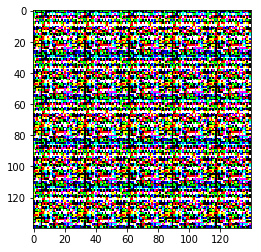

Epoch 1/1...1410 Discriminator Loss: 0.0000... Generator Loss: 11.1804
Epoch 1/1...1420 Discriminator Loss: 0.0000... Generator Loss: 11.0126
Epoch 1/1...1430 Discriminator Loss: 0.0000... Generator Loss: 10.7914
Epoch 1/1...1440 Discriminator Loss: 0.0000... Generator Loss: 11.2452
Epoch 1/1...1450 Discriminator Loss: 0.0000... Generator Loss: 11.5371
Epoch 1/1...1460 Discriminator Loss: 0.0000... Generator Loss: 11.6602
Epoch 1/1...1470 Discriminator Loss: 0.0001... Generator Loss: 11.4101
Epoch 1/1...1480 Discriminator Loss: 0.0000... Generator Loss: 11.5766
Epoch 1/1...1490 Discriminator Loss: 0.0000... Generator Loss: 11.3530
Epoch 1/1...1500 Discriminator Loss: 0.0000... Generator Loss: 11.4434


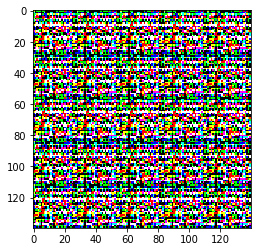

Epoch 1/1...1510 Discriminator Loss: 0.0000... Generator Loss: 11.3485
Epoch 1/1...1520 Discriminator Loss: 0.0000... Generator Loss: 11.0501
Epoch 1/1...1530 Discriminator Loss: 0.0000... Generator Loss: 11.0037
Epoch 1/1...1540 Discriminator Loss: 0.0000... Generator Loss: 11.2225
Epoch 1/1...1550 Discriminator Loss: 0.0000... Generator Loss: 11.4774
Epoch 1/1...1560 Discriminator Loss: 0.0000... Generator Loss: 11.4572
Epoch 1/1...1570 Discriminator Loss: 0.0000... Generator Loss: 11.2850
Epoch 1/1...1580 Discriminator Loss: 0.0000... Generator Loss: 11.5817
The residual time nearly to be:  0  minutes.


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。